In [2]:
from bisect import bisect
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

In [3]:
data = np.load('/Users/dp/Documents/清华/FilterData/data/sol_0.npy')

(51, 61, 61)


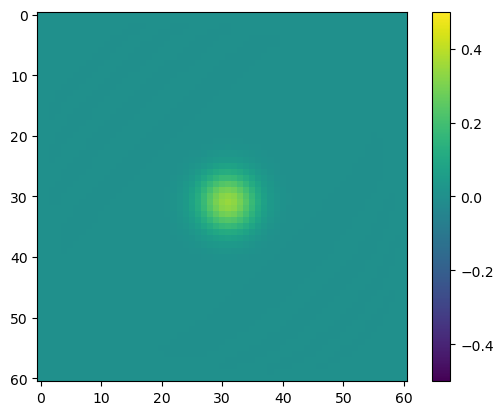

In [6]:
plt.figure()
plt.imshow(data[-1,:,:])
plt.colorbar()
plt.clim(-0.5,0.5)
plt.show()


In [16]:
from bisect import bisect
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn


class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(GaussianNormalizer, self).__init__()
        '''
        data: x,y,1
        target:x,y,2
        '''
        self.mean = torch.mean(x,dim = [0,1,2]).cpu().numpy()
        self.std = torch.std(x,dim = [0,1,2]).cpu().numpy()
        self.eps = eps
        print('mean',self.mean)
        print('std',self.std)
    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x
    def decode(self, x, sample_idx=None):
        x = (x * (self.std + self.eps)) + self.mean
        return x
    def cuda(self,device):
        self.mean = self.mean.to(device)
        self.std = self.std.to(device)
    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

class File_Loader(Dataset):
    #data loader file
    def __init__(self, data_paths, size =61,step=1):
        self.size = size    
        print('Start Data')
        self.data_memmaps = [np.load(path, mmap_mode='r')[::step,:,:] for path in data_paths]
        print('Loading Data Done')
        self.start_indices = [0] * len(data_paths) #4600
        self.data_count = 0 
        for index, memmap in enumerate(self.data_memmaps):
            self.start_indices[index] = self.data_count
            self.data_count += memmap.shape[0]-1
        #wandb.log({'data_count':self.data_count})
        #self.__gen_norm__()
    # def __gen_norm__(self):
    #     num = 100
    #     index = np.random.permutation(self.data_count_target)[:num]
    #     data_all = np.zeros((num,self.size,self.size))
    #     target_all = np.zeros((num,self.size,self.size),dtype = np.complex64)
    #     for i in range(num):
    #         if self.exp == 'single':
    #             memmap_index = bisect(self.start_indices_target, index[i]) - 1 #0-4600*8-1
    #             index_in_memmap = index[i] - self.start_indices_target[memmap_index] #0-8
    #             data_all[i,:,:] = np.copy(self.data_memmaps[memmap_index][0,:,:])
    #             target_all[i,:,:] = np.copy(self.target_memmaps[memmap_index][0,:,:])
    #         else:
    #             memmap_index = bisect(self.start_indices_target, index[i]) - 1 
    #             index_in_memmap = index[i] - self.start_indices_target[memmap_index] 
    #             index_1 = index[i]//64
    #             index_2 = index[i] - index_1*64
    #             data_all[i,:,:] = np.copy(self.data_memmaps[index_1][0,:,:])
    #             target_all[i,:,:] = np.copy(self.target_memmaps[memmap_index][index_in_memmap])
        
    #     self.data_norm = GaussianNormalizer(x = torch.tensor(data_all))
    #     self.target_norm = GaussianNormalizer(x = torch.tensor(target_all))       
    def __len__(self):
        return self.data_count #2400   
    def __getitem__(self, index):
        memmap_index = bisect(self.start_indices, index) - 1 #0-4600*8-1
        index_in_memmap = index - self.start_indices[memmap_index] #0-8
        #data = self.data_norm.encode(np.copy(self.data_memmaps[memmap_index][0,:,:]))
        data = self.data_memmaps[memmap_index][index_in_memmap,:,:]
        target = self.data_memmaps[memmap_index][index_in_memmap+1,:,:]
        return torch.tensor(data, dtype=torch.float).view(self.size,self.size,1), torch.tensor(target, dtype=torch.float).view(self.size,self.size,1)

class GettingLists(object):
    def __init__(self,train_num = 1600,
                    valid_num = 400 ,
                    PATH = 'lbs',
                    batchsize= int(2000)):
        super(GettingLists, self).__init__()
        self.PATH= PATH
        self.batchsize = batchsize
        self.valid_num = valid_num
        self.train_num = train_num
        self.data_list = (np.arange(self.train_num+self.valid_num)).tolist()
        self.data_list_train = self.data_list[:self.train_num]
        self.data_list_test = self.data_list[self.train_num:self.train_num+self.valid_num]
    def get_list(self, do):
        if do == 'train':
            train  = np.array([os.path.join(self.PATH,  
                                                        f'sol_{k}.npy') for k in \
                                                        self.data_list_train])
            return train
        elif do == 'validation':
            valid  = np.array([os.path.join(self.PATH,  
                                                        f'sol_{k}.npy') for k in \
                                                        self.data_list_test])
            return  valid
        elif do =='test':
            test  = np.array([os.path.join(self.PATH,  
                                                        f'sol_{k}.npy') for k in \
                                                        self.data_list_test])
            return  test
    def __call__(self, do = 'train'):
        return self.get_list(do)
    def get_dataloader(self,do,config):
        workers = config['data']['load_workers']
        size = config['data']['size']
        batchsize = self.batchsize
        step = config['data']['step']
        if do == 'train':
            list_train = self.__call__('train')
            list_valid = self.__call__('validation')
            Train_Data_set = File_Loader(list_train, size = size, step = step)
            Valid_Data_set = File_Loader(list_valid, size = size, step = step)
            train_loader = DataLoader(dataset = Train_Data_set, 
                                    shuffle = True, 
                                    batch_size = batchsize,
                                    num_workers= workers)
            valid_loader = DataLoader(dataset = Valid_Data_set, 
                                    shuffle = False, 
                                    batch_size =batchsize,
                                    num_workers= workers)
            return train_loader, valid_loader
        elif do == 'test':
            list_test = self.__call__('test')
            Test_Data_set = File_Loader(list_test, size = size, step = step)
            test_loader = DataLoader(dataset = Test_Data_set, 
                                    shuffle = False, 
                                    batch_size = batchsize,
                                    num_workers= workers)
            return test_loader

def datasetFactory(config,do='train'):
    c_data = config['data']
    gl = GettingLists(train_num = c_data["train_num"],
                     valid_num = c_data['valid_num'],
                     PATH = c_data["PATH"],
                     batchsize = c_data['batch'])
    return gl.get_dataloader(do = do,config = config)




In [17]:
import yaml
import argparse 
config_file = '/Users/dp/Documents/清华/Filter/fourier_neural_operator/config/fno2d.yaml'
with open(config_file, 'r') as stream:
        config = yaml.load(stream, yaml.FullLoader)
c_proj = config['Project']
train_dataloader, val_dataloader = datasetFactory(config=config, do=c_proj['do'])

Start Data
Loading Data Done
Start Data
Loading Data Done


In [18]:
num = train_dataloader.__len__()
print(num)
for batch_idx, batch in enumerate(train_dataloader):
    x,y = batch
    batchsize = x.shape[0]
    break
print(x.shape,y.shape)
x1 = x[0,:]
y1 = y[0,:]
x2 = x[1,:]
y2 = y[1,:]



1350


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/dp/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dp/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'File_Loader' on <module '__main__' (built-in)>


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()
ax0 = ax[0].imshow(x1[...,0], cmap="inferno")
ax[0].set_title("a(x)")
ax[1].imshow(y1[...,0], cmap="RdBu_r")
ax[1].set_title("GT u(x)")
ax[2].imshow(pred1.cpu(), cmap="RdBu_r")
ax[2].set_title("Pred u(x)")
plt.show()